In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Install necessary packages.
!pip install --upgrade --no-cache-dir dopamine-rl
!pip install cmake
!pip install atari_py
!pip install gin-config
%tensorflow_version 1.x

     |████████████████████████████████| 122kB 9.3MB/s 
     |████████████████████████████████| 163kB 15.1MB/s 
     |████████████████████████████████| 11.8MB 9.0MB/s 
     |████████████████████████████████| 358kB 51.2MB/s 
  Found existing installation: dopamine-rl 1.0.5
    Uninstalling dopamine-rl-1.0.5:
      Successfully uninstalled dopamine-rl-1.0.5
TensorFlow 1.x selected.


In [ ]:
#@title Create the new model with the higher entropies
import tensorflow as tf 
import gzip
import numpy as np 

SOURCE = 'Robotank'  # @param
TARGET = 'StarGunner'  # @param

# Return the entropy of a histogram
def entropy(kernel):
	pI=kernel/kernel.sum()
	y=[]
	for i in pI:
		if i==0:
			y.append(0)
		else:
			y.append(np.log2(i))
	return -np.sum(pI*y)

# Return the histogram of the feature map
def getHistogram(array):
	if np.amax(array)==0:
		return np.histogram(np.array(array)/0.000001,bins=(np.arange(101)/100))[0]
	return np.histogram(np.array(array)/np.amax(array),bins=(np.arange(101)/100))[0]

# Load the layers for evaluating the model
def loadLayers(weights, tf_session):
	layers=np.load(weights, allow_pickle=True)
	x=0
	for i in range(len(tf.trainable_variables())):
		if 'fully_connected' not in tf.trainable_variables()[i].name:
			tf_session.run(tf.assign(tf.trainable_variables()[i], layers[x]))
			x+=1
	print('Loaded layers =)')

def heatmapEntropies(heatmaps):
  entropies=[]
  for hm in heatmaps:
    entropies.append(entropy(getHistogram(hm)))
  return entropies

def get_Experience_Replay():
  # Load the Experience replay, we only use 2500 instances for test the model 
  # and get the new model with lower parameters
  ER_filename = '/content/drive/My Drive/Experience_Replay_Regresor/'+TARGET+'/$store$_observation_ckpt.0.gz'
  with tf.gfile.Open(ER_filename, 'rb') as f:
    with gzip.GzipFile(fileobj=f) as infile:
      return np.moveaxis(np.moveaxis(np.load(infile, allow_pickle=False)[:20000].reshape(5000,4,84,84),2,1),3,2)


def preserving_Info(percentage, array):
  k_to_erase=0
  for i in array:
    if i>=percentage:
      return k_to_erase
    k_to_erase+=1

Experience_Replay=get_Experience_Replay()
layers=['Online/Conv/Relu', 'Online/Conv_1/Relu', 'Online/Conv_2/Relu']

config = tf.ConfigProto(allow_soft_placement = True)

with tf.Session(config=config) as sess:
  #load the pre-trained model
  compression_kernels=[]
  saver = tf.train.import_meta_graph('/content/drive/My Drive/Experience_Replay_Regresor/aleatorio100/tf_ckpt-0.meta')
  saver.restore(sess,'/content/drive/My Drive/Experience_Replay_Regresor/aleatorio100/tf_ckpt-0')
  model_input = sess.graph.get_operation_by_name('state_ph').outputs[0]
  loadLayers('/content/drive/My Drive/Layers_Transfer_100/'+SOURCE+'.npy', sess)
  # full entropies: entropies that will be used in the compressed model
  full_entropies=[]
  conv_1=[]
  conv_2=[]
  conv_3=[]

  for instance in Experience_Replay:
    for layer in range(len(layers)):
      model_output = sess.graph.get_operation_by_name(layers[layer]).outputs[0]
      output=sess.run(model_output,feed_dict={model_input:np.expand_dims(instance, axis=0)})
      if layer==0:
        conv_1.append(heatmapEntropies(np.moveaxis(output[0],2,0)))
      elif layer==1:
        conv_2.append(heatmapEntropies(np.moveaxis(output[0],2,0)))
      else:
        conv_3.append(heatmapEntropies(np.moveaxis(output[0],2,0)))
  conv_1=np.mean(np.array(conv_1), axis=0)
  conv_2=np.mean(np.array(conv_2), axis=0)
  conv_3=np.mean(np.array(conv_3), axis=0)
  
  compression_kernels=[16,32,32]

  kernel_to_transfer=[]
  kernel_to_transfer.append(np.array(conv_1.argsort().tolist()[::-1]))
  kernel_to_transfer.append(np.array(conv_2.argsort().tolist()[::-1]))
  kernel_to_transfer.append(np.array(conv_3.argsort().tolist()[::-1]))
  
  layers=[]
  
  x=0
  for i in range(0,len(tf.trainable_variables()),2):
    if 'Conv' in tf.trainable_variables()[i].name:
      if i==0 or i==10:
        transfer_positions=np.sort(kernel_to_transfer[x]
                                 [0:compression_kernels[0]])
        layers.append(sess.run(tf.trainable_variables()[i])[:,:,:,transfer_positions])
        layers.append(sess.run(tf.trainable_variables()[i+1])[transfer_positions])
      else:
        transfer_positions=np.sort(kernel_to_transfer[x]
                                 [0:compression_kernels[x]])
        previous_transfer_positions=np.sort(kernel_to_transfer[x-1]
                                 [0:compression_kernels[x-1]])
        layers.append(sess.run(tf.trainable_variables()[i])
                                 [:,:,previous_transfer_positions][:,:,:,transfer_positions])
        layers.append(sess.run(tf.trainable_variables()[i+1])[transfer_positions])
      x+=1
      if x==3:
        x=0
  np.save('/content/drive/My Drive/Layers_Transfer_50/'+SOURCE+'_'+TARGET+'.npy', np.array(layers))
  sess.close()  

In [ ]:
#@title Necessary Imports and global parameters
import numpy as np
import tensorflow.compat.v1 as tf
import cv2
import sys
import gin.tf
from dopamine.agents.dqn import dqn_agent
from dopamine.discrete_domains import atari_lib
from dopamine.discrete_domains.atari_lib import NatureDQNNetwork
from dopamine.discrete_domains import run_experiment 
from dopamine.discrete_domains import checkpointer
from dopamine.discrete_domains import iteration_statistics
import collections
Layers_Path='/content/drive/My Drive/Layers_Transfer_50/'#+SOURCE+'_'+GAME+'.npy'
GAME = 'SpaceInvaders'  # @param
SOURCE=['Jamesbond', 'Assault'] # @param
WEIGHTS=[]
ONLINE=[]
TARGET=[]

for i in SOURCE:
  array=np.load(Layers_Path+i+'_'+GAME+'.npy',allow_pickle=True)
  print(len(array))
  for j in range(len(array)):
    if j < 6:
      ONLINE.append(array[j])
    else:
      TARGET.append(array[j])

for i in ONLINE:
  WEIGHTS.append(i)
for i in TARGET:
  WEIGHTS.append(i)

BASE_PATH='/content/drive/My Drive/Full_'+GAME
print(BASE_PATH)

12
12
/content/drive/My Drive/Full_SpaceInvaders


In [ ]:
# Create a new dqn with lower parameters
DQNNetworkType = collections.namedtuple('dqn_network', ['q_values'])
class ReducedDQN(atari_lib.NatureDQNNetwork):
  """The convolutional network used to compute the agent's Q-values."""

  def __init__(self, num_actions, name=None):
    """Creates the layers used for calculating Q-values.
    Args:
      num_actions: int, number of actions.
      name: str, used to create scope for network parameters.
    """
    super(NatureDQNNetwork, self).__init__(name=name)

    self.num_actions = num_actions
    # Defining layers.
    activation_fn = tf.keras.activations.relu
    # We transfer the weights from two task, an a half of kernels from each model
    # Part 1:
    self.conv_1_1 = tf.keras.layers.Conv2D(16, [8, 8], strides=4, padding='same',
                                        activation=activation_fn, name='Conv')
    self.conv_1_2 = tf.keras.layers.Conv2D(32, [4, 4], strides=2, padding='same',
                                        activation=activation_fn, name='Conv')
    self.conv_1_3 = tf.keras.layers.Conv2D(32, [3, 3], strides=1, padding='same',
                                        activation=activation_fn, name='Conv')
    #Set trainable layers in false
    self.conv_1_1.trainable=False
    self.conv_1_2.trainable=False
    self.conv_1_3.trainable=False
    
    #Part 2:
    self.conv_2_1 = tf.keras.layers.Conv2D(16, [8, 8], strides=4, padding='same',
                                        activation=activation_fn, name='Conv')
    self.conv_2_2 = tf.keras.layers.Conv2D(32, [4, 4], strides=2, padding='same',
                                        activation=activation_fn, name='Conv')
    self.conv_2_3 = tf.keras.layers.Conv2D(32, [3, 3], strides=1, padding='same',
                                        activation=activation_fn, name='Conv')
    #Set trainable layers in False
    self.conv_2_1.trainable=False
    self.conv_2_2.trainable=False
    self.conv_2_3.trainable=False


    self.conv_join = tf.keras.layers.Conv2D(48, [3, 3], strides=1, padding='same',
                                        activation=activation_fn, name='C_Join')
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(384, activation=activation_fn,
                                        name='fully_connected')
    self.dense2 = tf.keras.layers.Dense(num_actions, name='fully_connected')

  def call(self, state):
    #Input
    input = tf.cast(state, tf.float32)
    input = tf.div(input, 255.)
    #Part 1
    p1 = self.conv_1_1(input)
    p1 = self.conv_1_2(p1)
    p1 = self.conv_1_3(p1)
    #Part 2
    p2 = self.conv_2_1(input)
    p2 = self.conv_2_2(p2)
    p2 = self.conv_2_3(p2)
    #Concatenate
    x=tf.keras.layers.concatenate([p1,p2])
    x = self.conv_join(x)
    x = self.flatten(x)
    x = self.dense1(x)

    return DQNNetworkType(self.dense2(x))

In [ ]:
#We create a new runner for loading the weights and report mean +/- std

class myRunner(run_experiment.Runner):
    
    def __init__(self, base_dir, create_agent_fn):
        super(myRunner, self).__init__(base_dir, create_agent_fn)
    
    def _run_one_phase(self, min_steps, statistics, run_mode_str):
        step_count = 0
        num_episodes = 0
        sum_returns = 0.
        returns=[]
        while step_count < min_steps:
            episode_length, episode_return = self._run_one_episode()
            statistics.append({
              '{}_episode_lengths'.format(run_mode_str): episode_length,
              '{}_episode_returns'.format(run_mode_str): episode_return
            })
            step_count += episode_length
            sum_returns += episode_return
            num_episodes += 1
            returns.append(episode_return)
            # We use sys.stdout.write instead of tf.logging so as to flush frequently
            # without generating a line break.
            sys.stdout.write('Steps executed: {} '.format(step_count) +
                       'Episode length: {} '.format(episode_length) +
                       'Return: {}\r'.format(episode_return))
            sys.stdout.flush()
        print('Mean:',np.mean(np.array(returns)),'Std: +/- ',np.std(np.array(returns)))
        return step_count, sum_returns, num_episodes
    def _initialize_checkpointer_and_maybe_resume(self, checkpoint_file_prefix):
        self._checkpointer = checkpointer.Checkpointer(self._checkpoint_dir,
                                                   checkpoint_file_prefix)
        self._start_iteration = 0
        # Check if checkpoint exists. Note that the existence of checkpoint 0 means
        # that we have finished iteration 0 (so we will start from iteration 1).
        latest_checkpoint_version = checkpointer.get_latest_checkpoint_number(
        self._checkpoint_dir)
        if latest_checkpoint_version >= 0:
            experiment_data = self._checkpointer.load_checkpoint(
                               latest_checkpoint_version)
            if self._agent.unbundle(
                self._checkpoint_dir, latest_checkpoint_version, experiment_data):
                if experiment_data is not None:
                    assert 'logs' in experiment_data
                    assert 'current_iteration' in experiment_data
                    self._logger.data = experiment_data['logs']
                    self._start_iteration = experiment_data['current_iteration'] + 1
                    tf.logging.info('Reloaded checkpoint and will start from iteration %d',
                        self._start_iteration)
        else:
            #print('Algo')
            #layers=np.load(WEIGHTS, allow_pickle=True)
            x=0
            for i in range(len(tf.trainable_variables())):
              #print(tf.trainable_variables()[i].name)
              #print(tf.trainable_variables()[i].name)
              if 'Conv' in tf.trainable_variables()[i].name:
                #print(tf.trainable_variables()[i].name)
                #print(self._sess.run(tf.trainable_variables()[i]).shape)
                #print(WEIGHTS[x].shape)                
                self._sess.run(tf.assign(tf.trainable_variables()[i], WEIGHTS[x]))
                
                x+=1
            print('Loaded layers =)')
    def _run_one_iteration(self, iteration):
      statistics = iteration_statistics.IterationStatistics()
      #logging.info('Starting iteration %d', iteration)
      print('Starting iteration:', iteration)
      num_episodes_train, average_reward_train, average_steps_per_second = (
        self._run_train_phase(statistics))
      num_episodes_eval, average_reward_eval = self._run_eval_phase(
        statistics)
    
      self._save_tensorboard_summaries(iteration, num_episodes_train,
                                     average_reward_train, num_episodes_eval,
                                     average_reward_eval,
                                     average_steps_per_second)
      return statistics.data_lists

In [ ]:
def create_dqn_agent(sess, environment, summary_writer=None):
  """The Runner class will expect a function of this type to create an agent."""
  return dqn_agent.DQNAgent(sess, num_actions=environment.action_space.n, network=ReducedDQN)


#Reducir learning rate, aumentar batch size
dqn_config = """
import dopamine.agents.dqn.dqn_agent
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import gin.tf.external_configurables
create_agent.agent_name = 'dqn'
atari_lib.create_atari_environment.game_name = '{}'
atari_lib.create_atari_environment.sticky_actions = True
DQNAgent.tf_device = '/gpu:0'
tf.train.RMSPropOptimizer.learning_rate = 0.000025
run_experiment.Runner.num_iterations = 50
run_experiment.Runner.training_steps = 250000
run_experiment.Runner.max_steps_per_episode = 125000
WrappedReplayBuffer.batch_size = 64
""".format(GAME)
gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.agents.dqn.dqn_agent',
  'dopamine.discrete_domains.atari_lib',
  'dopamine.discrete_domains.run_experiment',
  'gin.tf.external_configurables'])

/content/drive/My Drive/Full_SpaceInvaders
Reading statistics from: /content/drive/My Drive/Full_SpaceInvaders//logs/log_49
1123.448275862069


<Figure size 432x288 with 0 Axes>

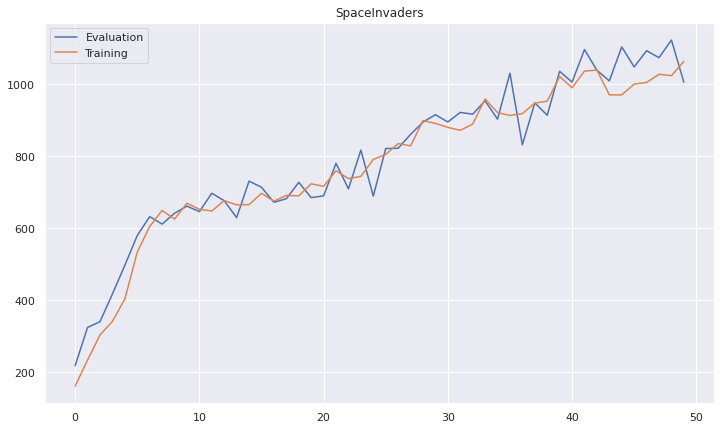

In [ ]:
from dopamine.colab import utils as colab_utils
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print(BASE_PATH)

plt.clf()
plt.figure(figsize=(12,7))
sns.set(style='darkgrid')
#print(colab_utils.read_experiment(BASE_PATH, verbose=True))
data=colab_utils.read_experiment(BASE_PATH, verbose=True, summary_keys=['train_episode_returns', 'eval_episode_returns'])
plt.title(GAME)
print(max(data['eval_episode_returns']))
plt.plot(data['eval_episode_returns'], label='Evaluation')
plt.plot(data['train_episode_returns'], label='Training')
plt.legend()
plt.show()

In [ ]:
runner = myRunner(BASE_PATH, create_dqn_agent)
runner.run_experiment()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Full_SpaceInvaders/checkpoints/tf_ckpt-44


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Full_SpaceInvaders/checkpoints/tf_ckpt-44


INFO:tensorflow:Reloaded checkpoint and will start from iteration 45


INFO:tensorflow:Reloaded checkpoint and will start from iteration 45


Starting iteration: 45
Mean: 1001.060606060606 Std: +/-  323.70782181260773
Mean: 1048.8202247191011 Std: +/-  304.83281702030337
Starting iteration: 46
Mean: 1005.7105263157895 Std: +/-  337.1246769133543
Mean: 1093.8333333333333 Std: +/-  346.7283999520855
Starting iteration: 47
Mean: 1028.4375 Std: +/-  357.61530228317037
Mean: 1074.4736842105262 Std: +/-  323.39195192619917
Starting iteration: 48
Mean: 1024.4946808510638 Std: +/-  330.0054560693451
Mean: 1123.448275862069 Std: +/-  307.7087277243156
Starting iteration: 49
Mean: 1064.207650273224 Std: +/-  312.52243730851507
Mean: 1006.1797752808989 Std: +/-  334.30039515038317
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.
